In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Praca domowa 7 - wykyrwanie obserwacji odstających
*Paweł Wojciechowski*

Celem zadania jest użycie modelu GMM (*Gaussian Mixture Modeling*) do wykrywania obserwacji odstających.
## Dane i model
Wczytajmy dane oraz dopasyjmy model `GaussianMixture` do danych treningowych.

In [23]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [24]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=1, n_init=10)
gm.fit(train_df)

GaussianMixture(n_init=10)

## Wizualziacja danych
Aby zwizualizować zbiór danych, standaryzujemy dane i redukujemy wymiarowość za pomocą PCA.

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=2))])
train_t = pipeline.fit_transform(train_df)

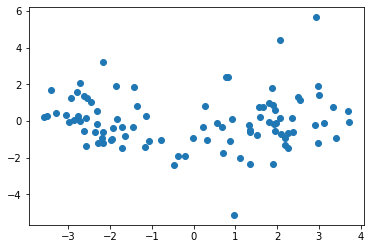

In [26]:
fig, ax = plt.subplots()
ax.scatter(x=train_t[:,0], y=train_t[:,1])
plt.show()

## Wybór progu decyzyjnego
Aby wykorzystać algorytm GMM do wykrywania obserwacji odstających potrzebujemy ustalić wartość gęstości, która będzie wyznaczać próg decyzyjny poniżej którego obserwacje zostaną zakwalifikowane jako odstające. 

Na wykresie widać rozkład wartości gęstości (przekstałcone przez funkcję `log`) dla zbioru treningowego. Na jego postawie wartość `-29` wydaje się być dobrym progiem decyzyjnym. Odcina tylko trzy najdalsze obserwacje odstające i jednocześnie nie znajduje się zbyt blisko skupiska wartości.

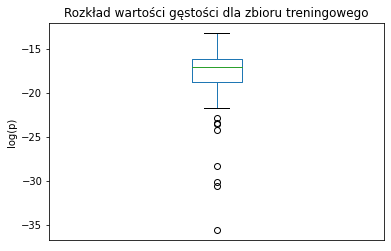

In [27]:
pd.Series(gm.score_samples(train_df)).plot.box()
plt.ylabel('log(p)')
plt.xticks([], [])
plt.title('Rozkład wartości gęstości dla zbioru treningowego')
plt.show()

## Wyniki 
Po ustaleniu progu, sprawdźmy jaki wynik uzyskamy na zbiorze testowym. 

Model GMM daje całkiem dobre wyniki wykrywania outlierów. Ze zbioru testowego tylko jeden punkt został źle sklasyfikowany (błąd typu false negative).

In [28]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
densities = gm.score_samples(test_df.drop(columns=['class']))
detected_labels = (densities < -29).astype('int')
print('Precision: ',precision_score(test_df['class'], detected_labels))
print('Recall: ', recall_score(test_df['class'], detected_labels))
print('F1: ',f1_score(test_df['class'], detected_labels))

Precision:  0.8333333333333334
Recall:  1.0
F1:  0.9090909090909091


Wizualizacja zbioru testowego z oznaczonym, źle sklasyfikowanym punktem.

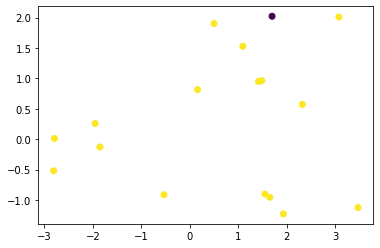

In [29]:
test_t = pipeline.transform(test_df.drop(columns=['class']))
test_df['result'] = test_df['class'] - detected_labels
fig, ax = plt.subplots()
ax.scatter(x=test_t[:,0], y=test_t[:,1], c=test_df['result'])
plt.show()

In [30]:
# różnice pomiędzy kasyfikacją a prawdziwymi oznaczeniami
test_df['result']

0     0
1     0
2     0
3    -1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
Name: result, dtype: int64